In [1]:
# Setup
!pip install -q \
transformers==4.40.1 \
datasets==2.19.1 \
torchaudio==2.2.2 \
librosa==0.10.1 \
soundfile==0.12.1 \
scikit-learn==1.4.2 \
pandas==2.2.2 \
numpy==1.26.4 \
peft==0.10.0 \
evaluate \
jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.7/253.7 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7

In [2]:
!pip uninstall -y torchao

Found existing installation: torchao 0.10.0
Uninstalling torchao-0.10.0:
  Successfully uninstalled torchao-0.10.0


In [3]:
!apt-get update -qq > /dev/null && apt-get install -y -qq sox libsox-dev libsox-fmt-all

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package libao-common.
(Reading database ... 129184 files and directories currently installed.)
Preparing to unpack .../00-libao-common_1.2.2+20180113-1.1ubuntu3_all.deb ...
Unpacking libao-common (1.2.2+20180113-1.1ubuntu3) ...
Selecting previously unselected package libao4:amd64.
Preparing to unpack .../01-libao4_1.2.2+20180113-1.1ubuntu3_amd64.deb ...
Unpacking libao4:amd64 (1.2.2+20180113-1.1ubuntu3) ...
Selecting previously unselected package libid3tag0:amd64.
Preparing to unpack .../02-libid3tag0_0.15.1b-14_amd64.deb ...
Unpacking libid3tag0:amd64 (0.15.1b-14) ...
Selecting previously unselected package libmad0:amd64.
Preparing to unpack .../03-libmad0_0.15.1b-10ubuntu1_amd64.deb ...
Unpacking libmad0:amd64 (0.15.1b-10ubuntu1) ...
Selecting previously unselected p

In [4]:
# Display audio
from IPython import display

def listen_to_sample(dataset, index=0):
    sample = dataset[index]
    print(f"Path: {sample['audio']['path']}")
    print(f"Transcription: {sample['sentence']}")
    display.display(display.Audio(sample['audio']['array'], rate=sample['audio']['sampling_rate']))

def play_audio(file_path: str):
    try:
        display.display(display.Audio(file_path))
    except Exception as e:
        print(f"Không thể phát audio: {e}")

In [5]:
# Normalize transcription
import re
def normalize_text(text):
    # All valid vietnamese tokens (excluding <pad>, <unk>)
    valid_chars = set(
        "abcdefghijklmnopqrstuvwxyz"
        "àáâãèéêìíòóôõùúý"
        "ăđĩũơư"
        "ạảấầẩẫậ"
        "ắằẳẵặ"
        "ẹẻẽếềểễệ"
        "ỉịọỏốồổỗộ"
        "ớờởỡợ"
        "ụủứừửữự"
        "ỳỵỷỹ"
        " "
    )

    text = text.lower()
    text = re.sub(r"[0-9]", "", text)
    text = re.sub(r"[^\w\s]|_", " ", text)  # remove punctuation, keep spaces
    text = re.sub(r"\s+", " ", text).strip()
    text = "".join([ch for ch in text if ch in valid_chars])
    return text

In [6]:
sample = "KHÁCH SẠN 123!!! Đà Lạt có mưa ☔"
print("Before:", sample)
print("After:", normalize_text(sample))

Before: KHÁCH SẠN 123!!! Đà Lạt có mưa ☔
After: khách sạn đà lạt có mưa


In [7]:
# Đường dẫn đầu vào trên Kaggle
VIVOS_ROOT = '/kaggle/input/vivos-vietnamese/vivos'
CV_ROOT    = '/kaggle/input/common-voice-vi-21/vi'
NOISE_ROOT = '/kaggle/input/musan-noise/musan/noise'

In [8]:
# Load vivos
import os
from datasets import Dataset

def load_vivos_dataset(vivos_root):
    prompts_path = os.path.join(vivos_root, "train", "prompts.txt")
    waves_root = os.path.join(vivos_root, "train", "waves")
    
    id2text = {}
    with open(prompts_path, "r", encoding="utf-8") as f:
        for line in f:
            audio_id, text = line.strip().split(maxsplit=1)
            id2text[audio_id] = text

    data = []
    for spk in os.listdir(waves_root):
        spk_dir = os.path.join(waves_root, spk)
        for f in os.listdir(spk_dir):
            audio_id = f.replace(".wav", "")
            if audio_id in id2text:
                data.append({
                    "audio": os.path.join(spk_dir, f),
                    "sentence": normalize_text(id2text[audio_id])
                })
    return Dataset.from_list(data)

In [9]:
vivos_dataset = load_vivos_dataset(VIVOS_ROOT)
print(vivos_dataset)
print(vivos_dataset[0])

Dataset({
    features: ['audio', 'sentence'],
    num_rows: 11660
})
{'audio': '/kaggle/input/vivos-vietnamese/vivos/train/waves/VIVOSSPK36/VIVOSSPK36_218.wav', 'sentence': 'hãy chọn phản ứng hóm hỉnh để chứng tỏ rằng bạn không bị lừa mà không làm căng thẳng tình hình'}


In [10]:
play_audio(vivos_dataset[0]['audio'])

In [11]:
# Load Common Voice Vi
import pandas as pd

def load_commonvoice_dataset(cv_root):
    clips_path = os.path.join(cv_root, "clips")
    df = pd.read_csv(os.path.join(cv_root, "validated.tsv"), sep="\t")

    data = []
    for i, row in df.iterrows():
        wav_path = os.path.join(clips_path, row["path"])
        if os.path.exists(wav_path):
            data.append({
                "audio": wav_path,
                "sentence": normalize_text(row["sentence"])
            })
    return Dataset.from_list(data)

In [12]:
cv_dataset = load_commonvoice_dataset(CV_ROOT)
print(cv_dataset)
print(cv_dataset[0])

Dataset({
    features: ['audio', 'sentence'],
    num_rows: 5191
})
{'audio': '/kaggle/input/common-voice-vi-21/vi/clips/common_voice_vi_30580094.mp3', 'sentence': 'ạ dạ không ạ ngại quá'}


In [13]:
play_audio(cv_dataset[0]['audio'])

In [14]:
# Cast Audio Column
from datasets import Audio
def prepare_dataset(ds):
    return ds.cast_column("audio", Audio(sampling_rate=16000))

In [15]:
# Check logic
vivos_audio = prepare_dataset(vivos_dataset)
print(vivos_audio)
print(vivos_audio[0])
print(vivos_audio[0]["audio"].keys())

Dataset({
    features: ['audio', 'sentence'],
    num_rows: 11660
})
{'audio': {'path': '/kaggle/input/vivos-vietnamese/vivos/train/waves/VIVOSSPK36/VIVOSSPK36_218.wav', 'array': array([0.        , 0.        , 0.        , ..., 0.00048828, 0.00030518,
       0.00039673]), 'sampling_rate': 16000}, 'sentence': 'hãy chọn phản ứng hóm hỉnh để chứng tỏ rằng bạn không bị lừa mà không làm căng thẳng tình hình'}
dict_keys(['path', 'array', 'sampling_rate'])


In [16]:
# Total Duration
def total_duration(dataset, label="dataset"):
    total_secs = sum(len(x["audio"]["array"]) / x["audio"]["sampling_rate"] for x in dataset)
    mins, secs = divmod(total_secs, 60)
    hours, mins = divmod(mins, 60)
    print(f"Total duration of {label}: {int(hours)}h {int(mins)}m {int(secs)}s ({total_secs/3600:.2f} hours)")

In [17]:
# Merge data
from datasets import concatenate_datasets, DatasetDict

def build_dataset_dict(vivos_root, cv_root, seed=42):
    vivos = prepare_dataset(load_vivos_dataset(vivos_root))
    cv = prepare_dataset(load_commonvoice_dataset(cv_root))
    
    merged = concatenate_datasets([vivos, cv]).shuffle(seed=seed)
    train_data, dev_data = merged.train_test_split(test_size=0.1, seed=seed).values()

    total_duration(train_data, "train")
    total_duration(dev_data, "validation")
    
    return DatasetDict({
        "train": train_data,
        "validation": dev_data
    })

In [18]:
ds_dict = build_dataset_dict(VIVOS_ROOT, CV_ROOT)
print(ds_dict)
print("Train sample:", ds_dict["train"][0])
print("Dev sample:", ds_dict["validation"][0])

Total duration of train: 18h 53m 18s (18.89 hours)
Total duration of validation: 2h 4m 17s (2.07 hours)
DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 15165
    })
    validation: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 1686
    })
})
Train sample: {'audio': {'path': '/kaggle/input/vivos-vietnamese/vivos/train/waves/VIVOSSPK09/VIVOSSPK09_R112.wav', 'array': array([0.00000000e+00, 3.05175781e-05, 0.00000000e+00, ...,
       1.49536133e-03, 1.15966797e-03, 8.54492188e-04]), 'sampling_rate': 16000}, 'sentence': 'mà khi chúng ta nắm giữ được'}
Dev sample: {'audio': {'path': '/kaggle/input/common-voice-vi-21/vi/clips/common_voice_vi_24125462.mp3', 'array': array([ 2.91038305e-11, -9.09494702e-12,  4.36557457e-11, ...,
        7.49308310e-06,  1.68580118e-05,  1.82972472e-05]), 'sampling_rate': 16000}, 'sentence': 'người nhà tao nói thế cho nên là lập miếu để thờ'}


In [19]:
print(ds_dict["train"][0]['audio']['path'])

/kaggle/input/vivos-vietnamese/vivos/train/waves/VIVOSSPK09/VIVOSSPK09_R112.wav


In [20]:
play_audio(ds_dict["train"][0]['audio']['path'])

In [21]:
play_audio(ds_dict["validation"][0]['audio']['path'])

In [22]:
# Load model and processor
from transformers import Wav2Vec2Config, Wav2Vec2ForCTC, Wav2Vec2Processor

# Tạo config riêng với SpecAugment
config = Wav2Vec2Config.from_pretrained("nguyenvulebinh/wav2vec2-base-vietnamese-250h")
config.mask_time_prob = 0.05
config.mask_time_length = 10
config.mask_feature_prob = 0.1
config.mask_feature_length = 10

# Load model với config mới, load processor
model = Wav2Vec2ForCTC.from_pretrained("nguyenvulebinh/wav2vec2-base-vietnamese-250h", config=config)
processor = Wav2Vec2Processor.from_pretrained("nguyenvulebinh/wav2vec2-base-vietnamese-250h")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:363: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of the model checkpoint at nguyenvulebinh/wav2vec2-base-vietnamese-250h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at nguyenvulebinh/wav2vec2-base-vietnamese-250h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You

preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

In [23]:
# Check
print(model.config.mask_time_prob) 
print(model.config.mask_feature_prob)
print("Vocab size:", processor.tokenizer.vocab_size)
print("Sampling rate:", processor.feature_extractor.sampling_rate)
print(processor.tokenizer.pad_token)

0.05
0.1
Vocab size: 110
Sampling rate: 16000
<pad>


In [24]:
# Speed Perturbation
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"   # hoặc "1"
import torchaudio, numpy as np, random, torch

def apply_speed_perturb(waveform: torch.Tensor, sampling_rate: int) -> torch.Tensor:
    speeds = [0.9, 1.0, 1.1]
    speed = random.choice(speeds)
    effects = [["speed", str(speed)], ["rate", str(sampling_rate)]]
    
    perturbed_waveform, _ = torchaudio.sox_effects.apply_effects_tensor(waveform, sampling_rate, effects)
    return perturbed_waveform

Original length:  134000
Perturbed length: 121818
Speed Ratio:      0.909 → Faster (Speed > 1.0)


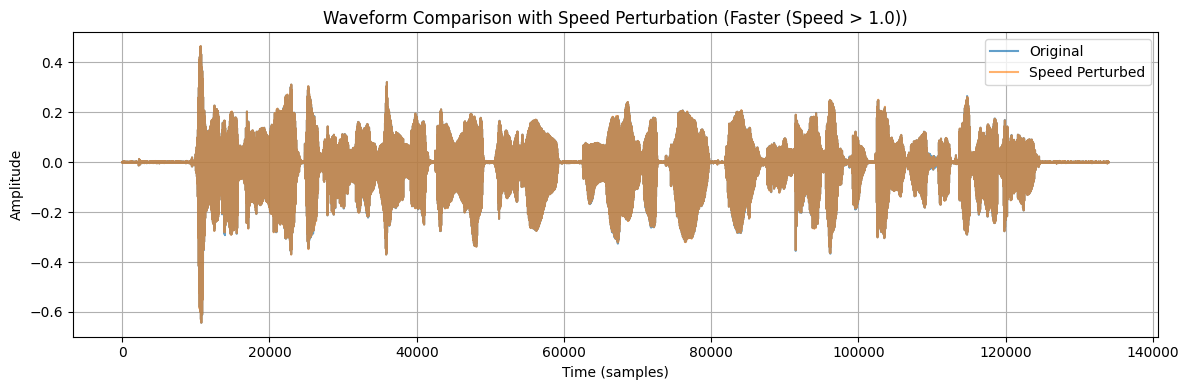

In [25]:
# Check
import matplotlib.pyplot as plt

# Lấy 1 sample từ tập train
sample = ds_dict["train"][-1]
waveform = torch.tensor(sample["audio"]["array"], dtype=torch.float32).unsqueeze(0)  # (1, T)
sampling_rate = sample["audio"]["sampling_rate"]

# Gọi speed perturb
perturbed_waveform = apply_speed_perturb(waveform, sampling_rate)

# Xác định tốc độ bị chọn
speed_ratio = perturbed_waveform.shape[1] / waveform.shape[1]
if speed_ratio > 1:
    speed_label = f"Slower (Speed < 1.0)"
elif speed_ratio < 1:
    speed_label = f"Faster (Speed > 1.0)"
else:
    speed_label = f"No change (Speed = 1.0)"

# In thông tin
print(f"Original length:  {waveform.shape[1]}")
print(f"Perturbed length: {perturbed_waveform.shape[1]}")
print(f"Speed Ratio:      {speed_ratio:.3f} → {speed_label}")

# Vẽ biểu đồ waveform
plt.figure(figsize=(12, 4))
plt.plot(waveform.squeeze().numpy(), label="Original", alpha=0.7)
plt.plot(
    np.linspace(0, waveform.shape[1]-1, perturbed_waveform.shape[1]),
    perturbed_waveform.squeeze().numpy(),
    label="Speed Perturbed", alpha=0.6
)
plt.legend()
plt.title(f"Waveform Comparison with Speed Perturbation ({speed_label})")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
# Get path for MUSAN noise
import os
from glob import glob

def get_musan_noise_paths(root_dir=NOISE_ROOT):
    musan_paths = []
    path = os.path.join(root_dir, 'free-sound')
    musan_paths.extend(glob(f"{path}/**/*.wav", recursive=True))
    return musan_paths

musan_paths = get_musan_noise_paths()

# Check
print("Total MUSAN files:", len(musan_paths))
print("Example:", musan_paths[0] if musan_paths else "No files found")

Total MUSAN files: 843
Example: /kaggle/input/musan-noise/musan/noise/free-sound/noise-free-sound-0626.wav


In [27]:
# Musan noise add
def add_noise(waveform: torch.Tensor, snr_dB: float, noise_paths: list) -> torch.Tensor:
    noise_path = random.choice(noise_paths)
    noise_waveform, _ = torchaudio.load(noise_path)

    if noise_waveform.size(1) < waveform.size(1):
        repeat_factor = int(np.ceil(waveform.size(1) / noise_waveform.size(1)))
        noise_waveform = noise_waveform.repeat(1, repeat_factor)
    noise_waveform = noise_waveform[:, :waveform.size(1)]

    speech_power = waveform.norm(p=2)
    noise_power = noise_waveform.norm(p=2)
    factor = (speech_power / noise_power) * 10 ** (-snr_dB / 20)

    return waveform + factor * noise_waveform

Original waveform shape: torch.Size([1, 46000])
Noised waveform shape:   torch.Size([1, 46000])
SNR target (dB): 12
Original power:  10.5240
Noised power:    10.8706


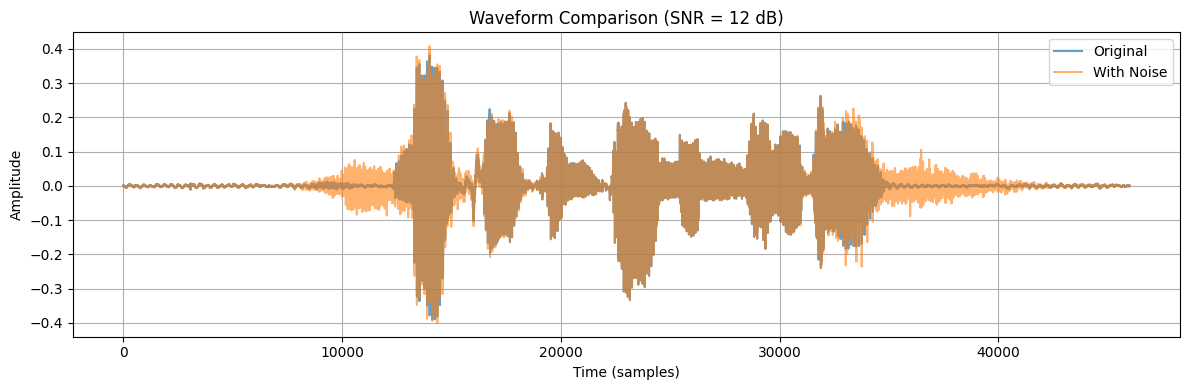

In [28]:
# Check
import matplotlib.pyplot as plt

# Lấy sample từ train
sample = ds_dict["train"][0]
waveform = torch.tensor(sample["audio"]["array"], dtype=torch.float32).unsqueeze(0)  # (1, T)
sampling_rate = sample["audio"]["sampling_rate"]

# Lưu lại bản gốc để so sánh
original_waveform = waveform.clone()

# Chọn snr và thêm noise
snr = 12  # dB
noised_waveform = add_noise(waveform, snr_dB=snr, noise_paths=musan_paths)

# Tính năng lượng (L2 norm)
original_power = original_waveform.norm(p=2).item()
noised_power = noised_waveform.norm(p=2).item()

# Hiển thị thông tin
print(f"Original waveform shape: {original_waveform.shape}")
print(f"Noised waveform shape:   {noised_waveform.shape}")
print(f"SNR target (dB): {snr}")
print(f"Original power:  {original_power:.4f}")
print(f"Noised power:    {noised_power:.4f}")

# Vẽ đồ thị waveform trước và sau
plt.figure(figsize=(12, 4))
plt.plot(original_waveform.squeeze().numpy(), label="Original", alpha=0.7)
plt.plot(noised_waveform.squeeze().numpy(), label="With Noise", alpha=0.6)
plt.legend()
plt.title(f"Waveform Comparison (SNR = {snr} dB)")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
def prepare_dataset(batch, do_augment=True):
    waveform = torch.tensor(batch["audio"]["array"], dtype=torch.float32).unsqueeze(0)
    sampling_rate = batch["audio"]["sampling_rate"]

    # Augment: speed + noise
    if do_augment:
        if random.random() < 0.9:
            waveform = apply_speed_perturb(waveform, sampling_rate)
        if random.random() < 0.8:
            snr = random.uniform(8, 20)
            waveform = add_noise(waveform, snr, musan_paths)

    waveform = waveform.squeeze(0).numpy()

    inputs = processor(waveform, sampling_rate=sampling_rate)
    batch["input_values"] = inputs.input_values[0]

    batch["labels"] = processor(text=batch["sentence"]).input_ids

    return batch

In [30]:
# Check
sample = ds_dict["train"][0]
out = prepare_dataset(sample)
print("Keys:", list(out.keys()))
print("Sentence:", out['sentence'])
print("Label IDs:", out["labels"])

2025-06-01 08:05:55.102031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748765155.534924      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748765155.655294      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Keys: ['audio', 'sentence', 'input_values', 'labels']
Sentence: mà khi chúng ta nắm giữ được
Label IDs: [67, 24, 46, 96, 71, 57, 46, 49, 71, 73, 26, 58, 46, 56, 17, 46, 26, 79, 67, 46, 58, 57, 78, 46, 89, 106, 69, 49]


In [31]:
# Áp dụng prepare_dataset cho ds_dict
from datasets import DatasetDict
processed_data = DatasetDict()

processed_data["train"] = ds_dict["train"].map(prepare_dataset, remove_columns=["audio", "sentence"],
    fn_kwargs={"do_augment": True})

processed_data["validation"] = ds_dict["validation"].map(prepare_dataset, remove_columns=["audio", "sentence"],
    fn_kwargs={"do_augment": False})

Map:   0%|          | 0/15165 [00:00<?, ? examples/s]

Map:   0%|          | 0/1686 [00:00<?, ? examples/s]

In [32]:
# Check
print(processed_data["train"][0].keys())
print(len(processed_data['train'][0]['input_values']))
print(processed_data['train'][0]['labels'])

dict_keys(['input_values', 'labels'])
41818
[67, 24, 46, 96, 71, 57, 46, 49, 71, 73, 26, 58, 46, 56, 17, 46, 26, 79, 67, 46, 58, 57, 78, 46, 89, 106, 69, 49]


In [33]:
def compute_length(example):
    example["length"] = len(example["input_values"])
    return example

processed_data["train"] = processed_data["train"].map(compute_length)
processed_data["train"] = processed_data["train"].sort("length")

Map:   0%|          | 0/15165 [00:00<?, ? examples/s]

In [34]:
# DataCollatorCTCWithPadding for Padding Batch
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorCTCWithPadding:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        input_features = [{"input_values": f["input_values"]} for f in features]
        label_features = [{"input_ids": f["labels"]} for f in features]

        batch = self.processor.feature_extractor.pad(input_features, padding=self.padding, return_tensors="pt")

        labels_batch = self.processor.tokenizer.pad(label_features, padding=self.padding, return_tensors="pt", return_attention_mask=True)

        labels = labels_batch["input_ids"].masked_fill(labels_batch["attention_mask"].ne(1), -100)
        batch["labels"] = labels

        return batch

In [35]:
# Check
collator = DataCollatorCTCWithPadding(processor=processor)
samples = [processed_data["train"][i] for i in range(4)]
batch = collator(samples)

# Check 1: Chiều dài được pad
input_lens = [len(s["input_values"]) for s in samples]
print("Raw input lengths:", input_lens)
print("After pad shape:", batch["input_values"].shape)

assert all(batch["input_values"].shape[1] >= l for l in input_lens)

# Check 2: labels có pad đúng -100
for i, label in enumerate(batch["labels"]):
    pad_mask = (label == -100).tolist()
    if any(pad_mask):
        first_pad = pad_mask.index(True)
        assert all(pad_mask[first_pad:]), f"Label {i} pad sai -100"

print("Padding cho input_values và labels OK.")

Raw input lengths: [12990, 14545, 16364, 17000]
After pad shape: torch.Size([4, 17000])
Padding cho input_values và labels OK.


In [36]:
# Wer
import evaluate
wer_metric = evaluate.load("wer")
def compute_metrics(pred):
    pred_ids = np.argmax(pred.predictions, axis=-1)
    pred_str = processor.batch_decode(pred_ids)
    label_ids = pred.label_ids
    # Chuyển -100 về pad_token_id
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, group_tokens=False)
    return {"wer": wer_metric.compute(predictions=pred_str, references=label_str)}

In [37]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"   # hoặc "1"
import torch, subprocess, os, platform
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU count:", torch.cuda.device_count())
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print("  Device", i, "=>", torch.cuda.get_device_name(i))
!nvidia-smi -L   # hiển thị tên GPU

PyTorch: 2.2.2+cu121
CUDA available: True
GPU count: 1
  Device 0 => Tesla T4
GPU 0: Tesla T4 (UUID: GPU-5acc2e5b-e6df-5f32-5799-e7df76571e42)
GPU 1: Tesla T4 (UUID: GPU-0e5c8607-8d6d-0c75-395f-38eda70d8b8c)


In [38]:
# Create TrainingArguments
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./wav2vec2_vi_ft",
    overwrite_output_dir=True,
    # Batching
    per_device_train_batch_size=8,           # 8 × 2 GPU × GA2 = 32
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    # Optimizer & schedule
    learning_rate=3e-5,
    warmup_ratio=0.06,                       # 6% of 7110 = 427 steps will increase learning rate from 0 -> 3e-5
    lr_scheduler_type="linear",              # After warming up, learning rate decreases linearly
    adam_beta1=0.9,                          
    adam_beta2=0.98,
    weight_decay=0.01,                       # L2 Regularization
    max_grad_norm=1.0,
    # Runtime
    num_train_epochs=15,                     # Dataloader steps / epoch: Ntrain / (2GPU * 8 batch) = 15165 / 16 = 948
    fp16=torch.cuda.is_available(),          # Optimizer steps / epoch: Dataloader steps / GA = 948 / 2 = 474
    # Logging/eval/save                      # Optimizer steps for 15 epochs: 474 x 15 = 7110
    evaluation_strategy="steps",
    eval_steps=250,                          # ~ 2 times for 1 epoch
    logging_steps=50,                        # ~ 10 times for 1 epoch
    save_steps=2000,                         # ~ 4 epochs for 1 checkpoint
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    report_to="tensorboard",
    logging_dir="./logs",
)

In [39]:
model.gradient_checkpointing_enable() # tiết kiệm VRAM
model.freeze_feature_encoder() # Freeze feature encoder

In [40]:
# Create Trainer
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=collator,
    args=training_args,
    train_dataset=processed_data["train"],
    eval_dataset=processed_data["validation"],
    tokenizer=processor,
    compute_metrics=compute_metrics
)

In [41]:
# Add callback for trainer
from transformers import TrainerCallback

FREEZE_EPOCHS = 3        # giữ đông cứng 0,1,2  → bắt đầu epoch = 3
LR_FACTOR = 0.3          # hạ 70 %


class SafeUnfreezeCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        if state.epoch == FREEZE_EPOCHS:
            # 1. Unfreeze feature extractor
            for p in model.wav2vec2.feature_extractor.parameters():
                p.requires_grad = True
            
            # 2. Reduce LR for *all* param groups
            for group in trainer.optimizer.param_groups:
                group["lr"] *= LR_FACTOR
            # Đồng bộ lại base_lrs của scheduler để khỏi nhảy vọt
            trainer.lr_scheduler.base_lrs = [g["lr"] for g in trainer.optimizer.param_groups]

            print(f">> Encoder unfrozen at epoch {state.epoch}. "
                  f"New LR = {trainer.optimizer.param_groups[0]['lr']:.2e}")
        return control
        
trainer.add_callback(SafeUnfreezeCallback())

In [42]:
# Train
trainer.train()

Step,Training Loss,Validation Loss,Wer
250,0.325700,0.168836,0.172063
500,0.316100,0.160870,0.173784
750,0.288500,0.154106,0.168726
1000,0.299600,0.154407,0.170134
1250,0.268700,0.146538,0.166171
1500,0.000000,nan,1.000000
1750,0.000000,nan,1.000000
2000,0.000000,nan,1.000000
2250,0.000000,nan,1.000000
2500,0.000000,nan,1.000000


>> Encoder unfrozen at epoch 3.0. New LR = 7.66e-06


TrainOutput(global_step=7110, training_loss=0.06934328535270423, metrics={'train_runtime': 19894.6762, 'train_samples_per_second': 11.434, 'train_steps_per_second': 0.357, 'total_flos': 1.6772479079163988e+19, 'train_loss': 0.06934328535270423, 'epoch': 15.0})

In [43]:
# Save
model.save_pretrained("/kaggle/working/wav2vec2_vi_ft")
processor.save_pretrained("/kaggle/working/wav2vec2_vi_ft")

[]

In [44]:
# Make archive
import shutil
shutil.make_archive("/kaggle/working/wav2vec2_vi_ft", 'zip', "/kaggle/working/wav2vec2_vi_ft")

'/kaggle/working/wav2vec2_vi_ft.zip'